In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, f1_score

In [26]:
def paint(d):
    df = d.copy().reset_index()
    plt.figure(figsize=(12, 3))
    colors = ["brown", "red", "purple", "green", "blue"]
    for i in range(len(df)):
        plt.scatter(i, df.loc[i, "X"], color=colors[df.loc[i, "y"]], marker='.')
    plt.show()

In [27]:
df = pd.read_csv("data.csv", index_col=0)
df.rename(columns={"yts": "X", "rampID": "y"}, inplace=True)
df["y"] -= 1

We have a series of subsequent values $y$ in the set $[0, 1, 2, 3, 4]$, where each sequence of subsequent identical values denote an event.
The values $y$ are affected in an _almost_ online fashion. Indeed, suppose the following sequence:

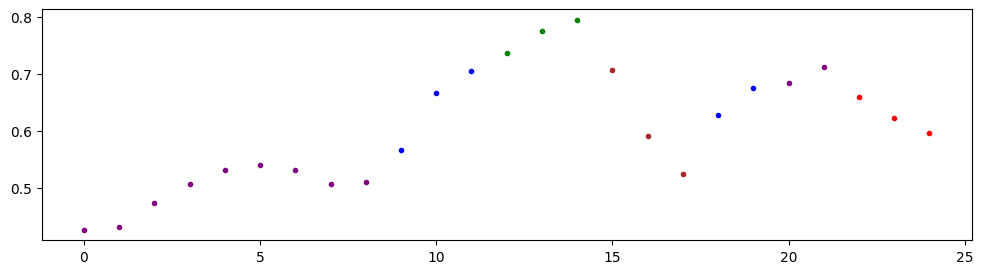

In [28]:
paint(df[25:50])

If one would like to label the next point, it would only have access to the labels until the last purple section. The last red event being not yet finished, non of the points of this sequence can be labelled. However, the measured quantities are accessible in an online fashion.

As a first strategy, we try to compute the probability $P(y|z)$, where $z$ is the last finished event label, and $y$ is in $[0, 1, 2, 3, 4]$. This can be computed for all $z$ in $[0, 1, 2, 3, 4]$.

We can then consider each event as an unique point, and then computing the probability of each sequence to be after one other.

In [45]:
sequence_of_event = [df.loc[0, "y"]]
for i in range(len(df)):
    if sequence_of_event[-1] != df.loc[i, "y"]:
        sequence_of_event.append(df.loc[i, "y"])

Here is the distribution of events (the length of the events is not taken into account):

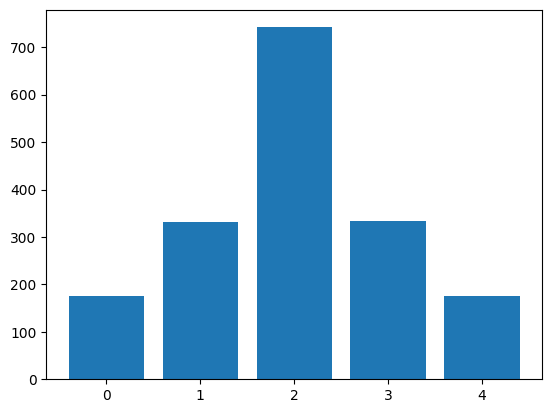

In [132]:
plt.bar([0, 1, 2, 3, 4], np.histogram(sequence_of_event, bins=5)[0])
plt.show()

In [92]:
p = [[0 for _ in range(5)] for _ in range(5)]
for i in range(1, len(sequence_of_event)):
    p[sequence_of_event[i-1]][sequence_of_event[i]] += 1
p = np.array(p, dtype=np.float64)

In [93]:
p = (p.T / np.sum(p, axis=0)).T

In [94]:
p

array([[0.        , 0.08      , 0.73142857, 0.10285714, 0.08571429],
       [0.05135952, 0.        , 0.7673716 , 0.13897281, 0.04229607],
       [0.14979757, 0.3414305 , 0.        , 0.33603239, 0.17273954],
       [0.06606607, 0.12612613, 0.75075075, 0.        , 0.05705706],
       [0.14204545, 0.125     , 0.61931818, 0.11363636, 0.        ]])

Here are the probability distribution for the label following each label:

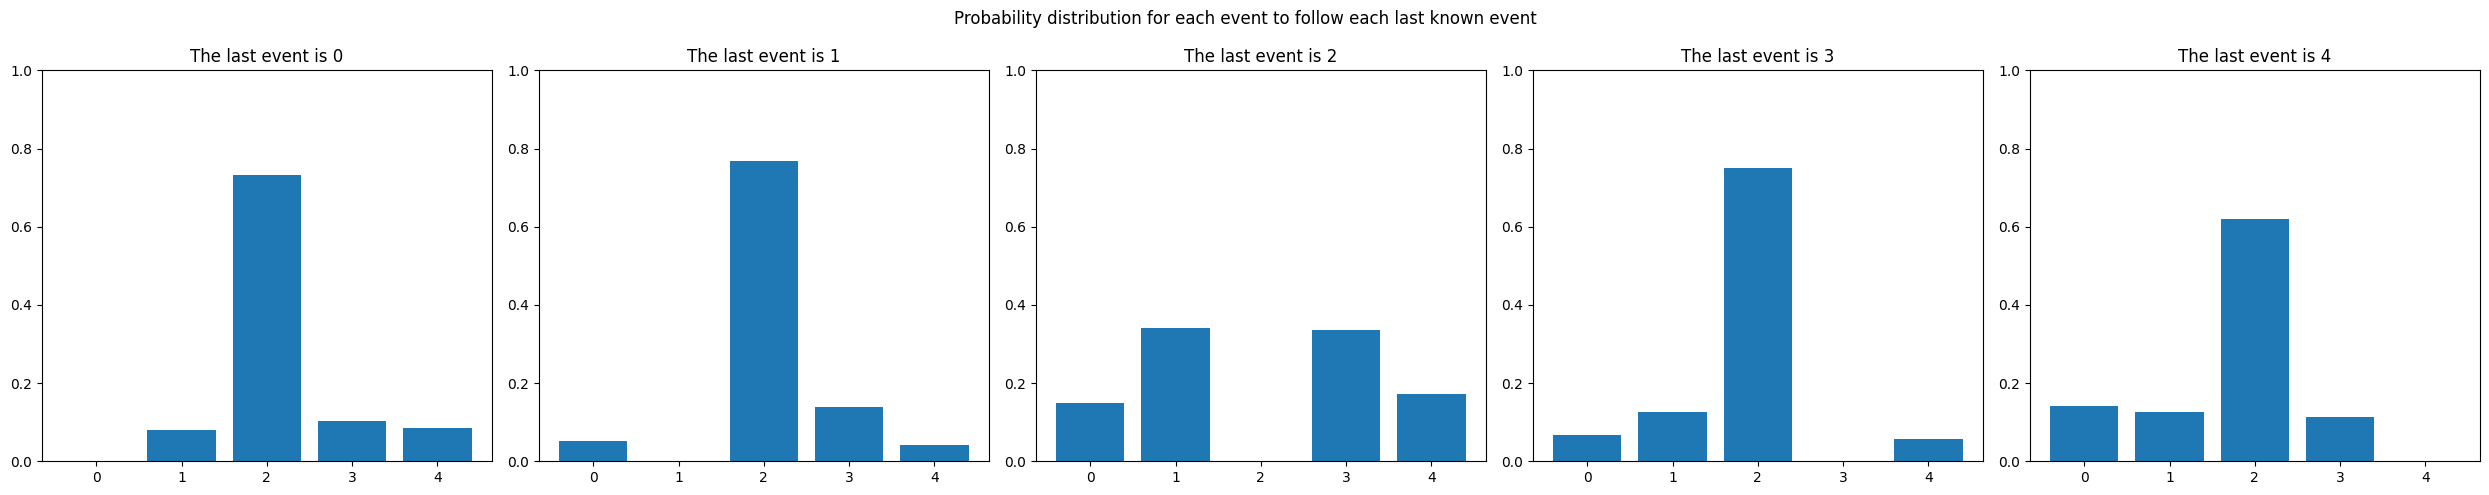

In [134]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
for i in range(5):
    ax[i].bar([0, 1, 2, 3, 4], p[i])
    ax[i].set_title(f"The last event is %i"%i)
    ax[i].set_ylim((0, 1))
plt.suptitle("Probability distribution for each event to follow each last known event")
plt.tight_layout()
plt.show()